In [ ]:
!pip install kaggle

In [ ]:
import os
import random
from collections import defaultdict
import matplotlib.pyplot as plt
from textwrap import wrap
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from matplotlib import rc
from pylab import rcParams
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from transformers import (
    AdamW,
    BertModel,
    BertTokenizer,
    get_linear_schedule_with_warmup,
)

In [ ]:

os.environ['KAGGLE_USERNAME'] = "vishakhaas"
os.environ['KAGGLE_KEY'] = "d6f9f1e38522fc8e86dba775c285da29"

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi
from zipfile import ZipFile

os.makedirs('data', exist_ok=True)

api = KaggleApi()
api.authenticate()
api.dataset_download_file('saeedaslimanesh/twitter-airline-sentiment', 'Tweets.csv')
zip_file = ZipFile('Tweets.csv.zip')
zip_file.extractall('data')
zip_file.close()
os.remove('Tweets.csv.zip')


Dataset URL: https://www.kaggle.com/datasets/saeedaslimanesh/twitter-airline-sentiment


In [ ]:
df = pd.read_csv('data/Tweets.csv')

In [ ]:
df.isna().sum()

,0
tweet_id,0
airline_sentiment,0
airline_sentiment_confidence,0
negativereason,5462
negativereason_confidence,4118
airline,0
airline_sentiment_gold,14600
name,0
negativereason_gold,14608
retweet_count,0


In [ ]:
print("Percentage null or na values in df")
((df.isnull() | df.isna()).sum() * 100 / df.index.size).round(2)

Percentage null or na values in df


,0
tweet_id,0.00
airline_sentiment,0.00
airline_sentiment_confidence,0.00
negativereason,37.31
negativereason_confidence,28.13
airline,0.00
airline_sentiment_gold,99.73
name,0.00
negativereason_gold,99.78
retweet_count,0.00


In [ ]:
del df['tweet_coord']
del df['airline_sentiment_gold']
del df['negativereason_gold']
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
freq = df.groupby('negativereason').size()
freq

,0
negativereason,
Bad Flight,580
Can't Tell,1190
Cancelled Flight,847
Customer Service Issue,2910
Damaged Luggage,74
Flight Attendant Complaints,481
Flight Booking Problems,529
Late Flight,1665
Lost Luggage,724


**NLP**

In [ ]:
import re
def pre_processing(df):
    df['text'] = df['text'].apply(lambda x: re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', x))
    df['text'] = df['text'].apply(lambda x: re.sub('(@[A-Za-z0-9_]+)','', x))
    df['text'] = df['text'].str.strip()
    df['text'] = df['text'].str.lower()



import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
df['tokens'] = df['text'].apply(word_tokenize)



from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])




from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
df['tokens'] = df['tokens'].apply(lambda x: [stemmer.stem(word) for word in x])





from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
df['tokens'] = df['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Light cleanup before tokenization
pre_processing(df)

# Encode labels
possible_labels = df.airline_sentiment.unique()
labels_map = {possible_labels[idx]: idx for idx, label in enumerate(possible_labels)}
df['labels'] = df.airline_sentiment.replace(labels_map)
print(df['labels'])

0        0
1        1
2        0
3        2
4        2
        ..
14635    1
14636    2
14637    0
14638    2
14639    0
Name: labels, Length: 14640, dtype: int64


<ipython-input-11-9ac79686a003>:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['labels'] = df.airline_sentiment.replace(labels_map)


In [ ]:
# Set color palette for plots
color = lambda: random.randint(0, 255)
colors = ['#%02X%02X%02X' %(color(), color(), color()) for i in range(6)]
sns.set_palette(sns.color_palette(colors))
rcParams['figure.figsize'] = 12, 10

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

# Check if cuda is enabled in the device
device = torch.cuda.is_available()

if not device:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


**UPSAMPLING**

<Axes: xlabel='airline_sentiment', ylabel='count'>

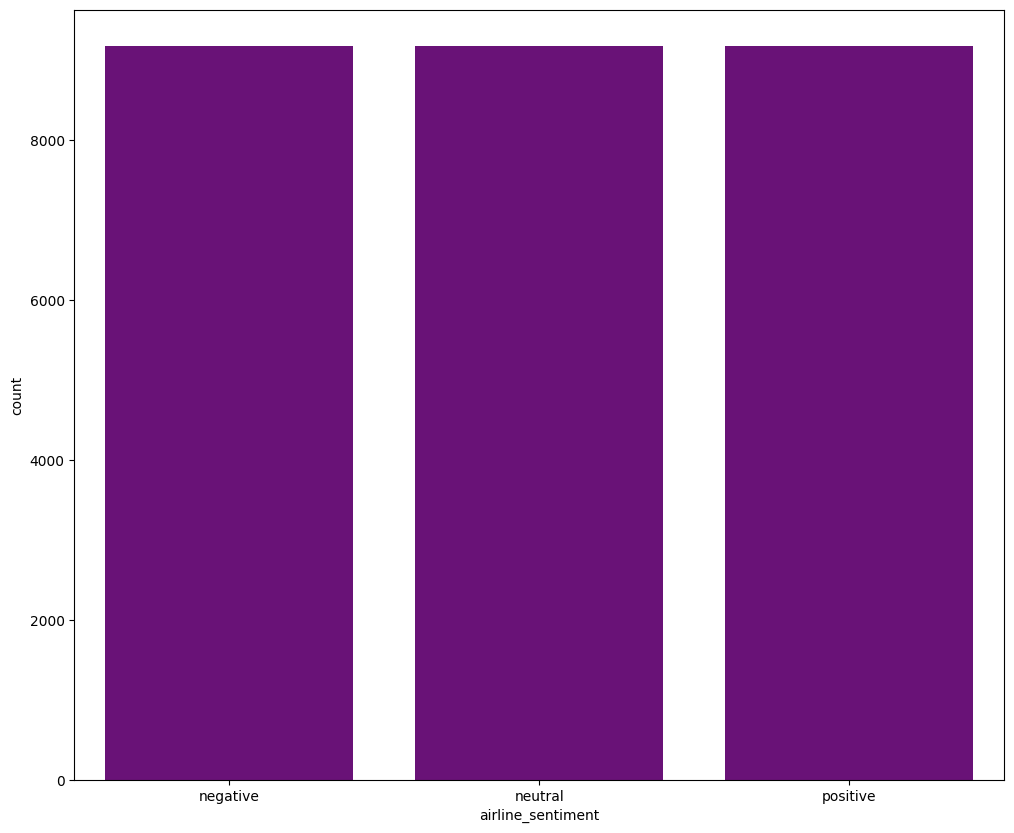

In [ ]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df.airline_sentiment=="negative"]
df_minority_neutral = df[df.airline_sentiment=="neutral"]
df_minority_positive = df[df.airline_sentiment=="positive"]

# Upsample minority classes
df_minority_neutral_upsampled = resample(df_minority_neutral,
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=RANDOM_STATE)  # reproducible results

df_minority_positive_upsampled = resample(df_minority_positive,
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=RANDOM_STATE)  # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_neutral_upsampled, df_minority_positive_upsampled])

# Display new class counts
df_upsampled.airline_sentiment.value_counts()
sns.countplot(x=df_upsampled.airline_sentiment)


In [ ]:
def tweet_to_words(tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",tweet)
    words = letters_only.lower().split()
    stops = set(stopwords.words("english"))
    meaningful_words = [w for w in words if not w in stops]
    return( " ".join( meaningful_words ))

nltk.download('stopwords')
df['clean_tweet']=df['text'].apply(lambda x: tweet_to_words(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Check the cleaned tweet column
df[['text', 'clean_tweet']].head()

,text,clean_tweet
0,what said.,said
1,plus you've added commercials to the experienc...,plus added commercials experience tacky
2,i didn't today... must mean i need to take ano...,today must mean need take another trip
3,"it's really aggressive to blast obnoxious ""ent...",really aggressive blast obnoxious entertainmen...
4,and it's a really big bad thing about it,really big bad thing


In [ ]:
# Check the sentiment labels
df[['airline_sentiment', 'labels']].head()


,airline_sentiment,labels
0,neutral,0
1,positive,1
2,neutral,0
3,negative,2
4,negative,2


In [ ]:
# View the first 5 rows of 'airline_sentiment' and 'clean_tweet'
df[['airline_sentiment', 'clean_tweet']].head()

,airline_sentiment,clean_tweet
0,neutral,said
1,positive,plus added commercials experience tacky
2,neutral,today must mean need take another trip
3,negative,really aggressive blast obnoxious entertainmen...
4,negative,really big bad thing


In [ ]:
# Select the relevant columns and save to CSV
df[['airline_sentiment', 'clean_tweet']].to_csv('cleaned_tweets.csv', index=False)


In [ ]:
from google.colab import files

# Download the CSV file
files.download('cleaned_tweets.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>